In [8]:
import json
import numpy as np
import random
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from sklearn.preprocessing import LabelEncoder
from collections import Counter

In [9]:

# === 1. Carga y Preprocesamiento de Datos === #
with open('chatbot_data.json') as file:
    data = json.load(file)

training_sentences = []
training_labels = []
labels = []
responses = []

for intent in data['intents']:
    for pattern in intent['patterns']:
        training_sentences.append(pattern)
        training_labels.append(intent['tag'])
    responses.append(intent['responses'])

    if intent['tag'] not in labels:
        labels.append(intent['tag'])

num_classes = len(labels)


In [10]:
# Codificación de etiquetas
lbl_encoder = LabelEncoder()
lbl_encoder.fit(training_labels)
training_labels = lbl_encoder.transform(training_labels)

# Tokenización y Padding
vocab_size = 2000
embedding_dim = 50
max_len = 25
oov_token = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(training_sentences)
sequences = tokenizer.texts_to_sequences(training_sentences)
padded_sequences = pad_sequences(sequences, truncating='post', maxlen=max_len)

# Chequeo de clases desequilibradas y ajuste de pesos
class_counts = Counter(training_labels)
class_weights = {i: max(class_counts.values()) / count for i, count in class_counts.items()}



In [11]:

# Modelo simplificado
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(128, activation='relu', kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compilación
optimizer = Adam(learning_rate=1e-3)  # Aumentar tasa de aprendizaje inicial
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-6)

# Entrenamiento
history = model.fit(
    padded_sequences,
    np.array(training_labels),
    validation_split=0.2,
    batch_size=32,
    epochs=200,
    callbacks=[early_stop, reduce_lr]
)


c:\Users\Chiquigamer\anaconda3\envs\Canemcat\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.0261 - loss: 6.0307 - val_accuracy: 0.0000e+00 - val_loss: 5.2868 - learning_rate: 0.0010
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0893 - loss: 5.5164 - val_accuracy: 0.0000e+00 - val_loss: 5.2281 - learning_rate: 0.0010
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0712 - loss: 5.2129 - val_accuracy: 0.0000e+00 - val_loss: 5.1776 - learning_rate: 0.0010
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1504 - loss: 5.0029 - val_accuracy: 0.0000e+00 - val_loss: 5.1308 - learning_rate: 0.0010
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1793 - loss: 4.5557 - val_accuracy: 0.0000e+00 - val_loss: 5.0894 - learning_rate: 0.0010
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1780 - loss: 4.4791 - val_accuracy: 0.0000e+00 - val_loss: 5.0536 - learning_rate: 0.0010
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1723 - loss:

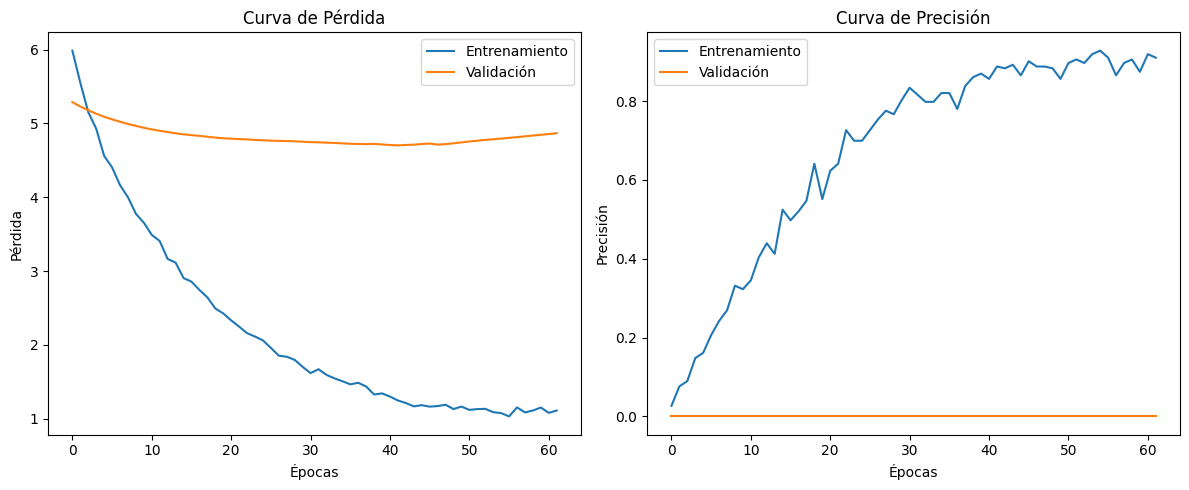

In [12]:
# === 4. Visualización de Resultados === #

plt.figure(figsize=(12, 5))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Curva de Pérdida')

# Precisión
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.title('Curva de Precisión')

plt.tight_layout()
plt.show()

In [13]:
# === 6. Guardado del Modelo y Componentes === #
model.save("chat_model.keras")

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('label_encoder.pickle', 'wb') as ecn_file:
    pickle.dump(lbl_encoder, ecn_file, protocol=pickle.HIGHEST_PROTOCOL)


In [14]:
# === 6. Guardado del Modelo y Componentes === #
model.save("chat_model.keras")

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('label_encoder.pickle', 'wb') as ecn_file:
    pickle.dump(lbl_encoder, ecn_file, protocol=pickle.HIGHEST_PROTOCOL)

# === 7. Función para Interacción === #
def chat():
    """Función para interactuar con el chatbot."""
    from tensorflow.keras.models import load_model

    # Cargar modelo entrenado
    model = load_model('chat_model.keras')

    # Cargar tokenizador
    with open('tokenizer.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)

    # Cargar codificador de etiquetas
    with open('label_encoder.pickle', 'rb') as enc:
        lbl_encoder = pickle.load(enc)

    max_len = 25
    print("¡Habla con el bot! Escribe 'quit' para salir.")
    while True:
        inp = input("Usuario: ")
        if inp.lower() == "quit":
            break

        result = model.predict(pad_sequences(tokenizer.texts_to_sequences([inp]), maxlen=max_len))
        tag = lbl_encoder.inverse_transform([np.argmax(result)])
        for intent in data['intents']:
            if intent['tag'] == tag[0]:
                print("ChatBot:", random.choice(intent['responses']))
                break

# Iniciar el chatbot
chat()


¡Habla con el bot! Escribe 'quit' para salir.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
ChatBot: ¡Saludos! ¿Cómo estás?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
ChatBot: Si deseas adoptar, primero regístrate en nuestra plataforma. Posteriormente, te invitaremos a realizar un test de compatibilidad que nos permitirá recomendarte el animal que más se ajuste a ti.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
ChatBot: ¡Nos vemos! Que tengas un excelente día.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
ChatBot: Solo los trabajadores tienen acceso para gestionar los animales. Puedes hacerlo a través de tu panel de trabajador. ¿Te gustaría añadir o modificar un animal?
